# Fighter's Stance vs Strikes Landed per Minute
### ~One-Way ANOVA 

In [1]:
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [1]:
#Setting theme
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [37]:
# For data cleaning/feature engineering
import numpy as np
import pandas as pd

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt

#For predicting missing values
from sklearn.tree import DecisionTreeClassifier

#For statistical tests
import pingouin as pg
import statsmodels as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import levene
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats.multicomp import TukeyHSDResults
from statsmodels.stats.diagnostic import kstest_normal
from scipy.stats import shapiro

In [62]:
sns.set(style = 'darkgrid', palette = 'bright')
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (15, 10)
plt.style.use('ggplot')
%matplotlib inline

#### This data is scraped from ufcstats.com in google colab. It's in the same repository

In [115]:
df = pd.read_csv('fighter_stance.csv') 

##### The scraped data is large enough, let's try to shrink it a little bit

In [116]:
def reduce_mem_usage(df, n_unique_threshold):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage before: {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        
        elif col_type=='object':
            if df[col].nunique()<=n_unique_threshold: 
                df[col] =  df[col].astype('category') 
            else:
                pass

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage now : {:.2f} MB'.format(end_mem))
    print('Memory usage decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [117]:
reduce_mem_usage(df, 10) 

Memory usage before: 0.20 MB
Memory usage now : 0.09 MB
Memory usage decreased by 57.0%


,name,last_name,stance,wins,losses,SLpM,fights
0,Tom,Aaron,NaN,5,3,0.000000,8
1,Danny,Abbadi,Orthodox,4,6,3.289062,10
2,David,Abbott,Switch,10,15,1.349609,25
3,Shamil,Abdurakhimov,Orthodox,20,6,2.529297,26
4,Hiroyuki,Abe,Orthodox,8,15,1.709961,23
...,...,...,...,...,...,...,...
3736,Dave,Zitanick,NaN,5,7,0.000000,12
3737,Alex,Zuniga,NaN,6,3,0.000000,9
3738,George,Zuniga,NaN,3,1,7.640625,4
3739,Allan,Zuniga,Orthodox,13,1,3.929688,14


In [118]:
display(df.tail(), df.info(), df.groupby('stance')['SLpM'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3741 entries, 0 to 3740
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   name       3737 non-null   object  
 1   last_name  3741 non-null   object  
 2   stance     2933 non-null   category
 3   wins       3741 non-null   int16   
 4   losses     3741 non-null   int8    
 5   SLpM       3741 non-null   float16 
 6   fights     3741 non-null   int16   
dtypes: category(1), float16(1), int16(2), int8(1), object(2)
memory usage: 88.0+ KB


,name,last_name,stance,wins,losses,SLpM,fights
3736,Dave,Zitanick,NaN,5,7,0.000000,12
3737,Alex,Zuniga,NaN,6,3,0.000000,9
3738,George,Zuniga,NaN,3,1,7.640625,4
3739,Allan,Zuniga,Orthodox,13,1,3.929688,14
3740,Virgil,Zwicker,NaN,15,6,3.339844,21


None

,count,mean,std,min,25%,50%,75%,max
stance,,,,,,,,
Open Stance,7.0,1.716797,1.786133,0.0,0.709961,0.799805,2.419434,4.960938
Orthodox,2269.0,2.685547,1.786133,0.0,1.419922,2.609375,3.710938,16.593750
Sideways,3.0,0.093323,0.161743,0.0,0.000000,0.000000,0.140015,0.280029
Southpaw,508.0,2.535156,1.603516,0.0,1.377441,2.415039,3.490234,10.531250
Switch,146.0,3.300781,2.242188,0.0,1.932373,2.985352,4.416992,12.070312


### Exploratory Data Analysis (EDA)

In [119]:
#Checking the mean and number of samples per stance cat
df.groupby('stance')['SLpM'].agg(['count', 'mean']) 

,count,mean
stance,,
Open Stance,7,1.716797
Orthodox,2269,2.685547
Sideways,3,0.093323
Southpaw,508,2.535156
Switch,146,3.300781


In [120]:
#Removing the stance categories that have very few values. We'll conduct tests on 3
df = df[(df['stance']!='Open Stance') & (df['stance']!='Sideways')]

In [121]:
print(f'''Number of rows left: {df.shape[0]}''')

Number of rows left: 3731


In [122]:
#Missing stance records
df[df['stance'].isna()].shape[0]

808

In [123]:
#Around 60% of the missing null values have 0 SLpM
len(df[(df['stance'].isna()) & (df['SLpM']==0)])/len(df[df['stance'].isna()])

0.5928217821782178

#### We'll check the SLpM column records that have zero values
##### What causes this?

In [124]:
df[df['SLpM']==0].shape[0] 

728

In [125]:
#Let's find what percent of 0 SLpM values are when the stance is not null
df[(df['SLpM']==0) & (df['stance'].notna())]

,name,last_name,stance,wins,losses,SLpM,fights
10,Scott,Adams,Southpaw,8,1,0.0,9
15,Sam,Adkins,Orthodox,7,20,0.0,27
18,Marcelo,Aguiar,Orthodox,2,3,0.0,5
38,Wes,Albritton,Orthodox,0,1,0.0,1
60,Royce,Alger,Orthodox,3,2,0.0,5
...,...,...,...,...,...,...,...
3652,Cal,Worsham,Orthodox,13,10,0.0,23
3669,Keiichiro,Yamamiya,Southpaw,45,35,0.0,80
3684,Masutatsu,Yano,Orthodox,2,4,0.0,6
3688,Yoshiaki,Yatsu,Orthodox,0,2,0.0,2


In [126]:
#Checking how many fights have they fought when SLpM is null
df[df['SLpM']==0]['fights'].value_counts()

1      74
5      50
2      48
3      46
6      45
4      40
7      37
8      36
10     30
11     28
15     22
12     22
13     21
9      21
16     21
18     20
14     16
22     15
20     15
19     14
21     11
0      11
17      9
29      7
27      7
25      5
24      5
23      5
37      4
36      3
45      3
26      3
40      3
33      2
32      2
31      2
39      2
30      2
44      2
28      2
35      2
48      2
55      2
58      1
120     1
107     1
85      1
80      1
46      1
54      1
49      1
41      1
38      1
306     1
Name: fights, dtype: int64

In [127]:
df[(df['fights']<=5) & (df['SLpM']==0.00)]

,name,last_name,stance,wins,losses,SLpM,fights
18,Marcelo,Aguiar,Orthodox,2,3,0.0,5
32,Javi,Alanis,NaN,0,4,0.0,4
35,Brett,Albee,NaN,3,2,0.0,5
38,Wes,Albritton,Orthodox,0,1,0.0,1
41,Juan,Alcain,NaN,1,2,0.0,3
...,...,...,...,...,...,...,...
3688,Yoshiaki,Yatsu,Orthodox,0,2,0.0,2
3693,John,Yoo,NaN,0,1,0.0,1
3705,Han Ten,Yun,NaN,0,1,0.0,1
3727,Zhang,Minyang,NaN,0,0,0.0,0


In [128]:
#People who have fought fewer or equal to 5 fights have around 63% zero SLpM record
df[(df['fights']<=5) & (df['SLpM']==0.00)].shape[0]/df[df['fights']<=5].shape[0]  

0.6389548693586699

In [129]:
over = [f for f in df[df['stance'].isna()]['fights'].values if f<=5] 
len(over)/len(list(df[df['stance'].isna()]['fights'].values))  

0.26732673267326734

In [130]:
df[df['fights']<=5].groupby('stance')['SLpM'].mean()

stance
Open Stance         NaN
Orthodox       1.364258
Sideways            NaN
Southpaw       0.536621
Switch         2.292969
Name: SLpM, dtype: float16

In [131]:
df[df['fights']>=5].groupby('stance')['SLpM'].mean()

stance
Open Stance         NaN
Orthodox       2.781250
Sideways            NaN
Southpaw       2.636719
Switch         3.373047
Name: SLpM, dtype: float16

In [132]:
'''Here, we're filtering out all the cases that don't meet our predefined mininum.
However, this should't always be the case since we're throwing away some useful information'''

df = df[df['fights']>5]

In [133]:
#We discover that most 0 SLpM values are with null stance. We'll have to remove these as well
df[(df['SLpM']==0.00) & (df['stance'].isna())]

,name,last_name,stance,wins,losses,SLpM,fights
0,Tom,Aaron,NaN,5,3,0.0,8
19,Fabio,Aguiar,NaN,17,1,0.0,18
20,Edwin,Aguilar,NaN,26,19,0.0,45
57,Pablo,Alfonso,NaN,9,7,0.0,16
58,Levi,Alford,NaN,1,7,0.0,8
...,...,...,...,...,...,...,...
3689,Chris,Yee,NaN,4,6,0.0,10
3699,Artenus,Young,NaN,10,12,0.0,22
3712,Joao,Zaiden,NaN,10,3,0.0,13
3736,Dave,Zitanick,NaN,5,7,0.0,12


In [134]:
df = df[(df['SLpM']!=0.00) | (df['stance'].notna())]

In [135]:
#The code above ensures that these two cases below no longer intersect
print(f'''Number of zero SLpM records now: {df[df['SLpM']==0.00].shape[0]}'''),
print(f'''Number of null stance records now: {df[df['stance'].isna()].shape[0]}''')        

Number of zero SLpM records now: 154
Number of null stance records now: 287


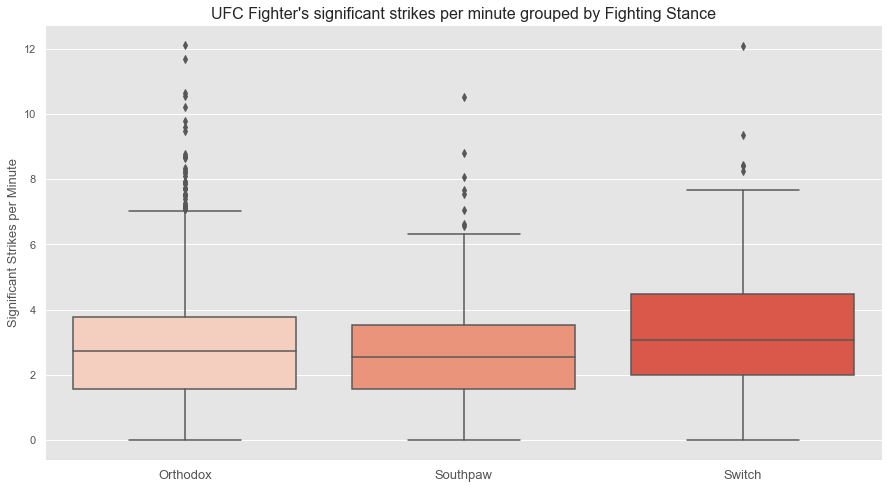

In [136]:
#Visualizing the mean comparison
#But this is not conclusive
plt.figure(figsize=(15,8))
sns.set_palette("Reds", 4)
sns.boxplot(x="stance",y="SLpM",data=df,order=["Orthodox", "Southpaw", "Switch"])
#sns.stripplot(x="stance", y="SLpM", data=df, order=["Orthodox", "Southpaw", "Switch"], jitter=0.4, color="0.3")
plt.title("UFC Fighter's significant strikes per minute grouped by Fighting Stance", fontsize=16)
plt.xlabel("")
plt.xticks([0,1,2],["Orthodox","Southpaw","Switch"],fontsize=13)
plt.ylabel("Significant Strikes per Minute", fontsize=13)

#Save to downloads folder
plt.savefig("stance_boxplot.png")

plt.show()

In [137]:
#Number of 0 SLpm's per stance
df[df['SLpM']==0].groupby('stance')['name'].agg('count')

stance
Open Stance      0
Orthodox       121
Sideways         0
Southpaw        22
Switch          11
Name: name, dtype: int64

In [138]:
'''We've got fighters here who've fought numerous times but have 0 SLpM.
I've found out that these particular fighters have very few fights in the UFC itself (via the site),
excluding the prelims. So, these fighters are excluded from the tests'''

df = df[df['SLpM']!=0]

In [139]:
#Lastly, it's time to deal with the missing stance records before running the tests
df.isna().sum()

name           4
last_name      0
stance       287
wins           0
losses         0
SLpM           0
fights         0
dtype: int64

In [140]:
#Rechecking
df.groupby('stance')['SLpM'].agg(['count', 'mean', 'median'])

,count,mean,median
stance,,,
Open Stance,0,NaN,NaN
Orthodox,1981,2.960938,2.820312
Sideways,0,NaN,NaN
Southpaw,456,2.789062,2.619141
Switch,127,3.650391,3.470703


In [141]:
df = df.iloc[:, 2:-1]
df['stance'].replace('Orthodox' , '0', inplace=True)
df['stance'].replace('Southpaw' , '1', inplace=True)
df['stance'].replace('Switch' , '2', inplace=True) 
df.reset_index(drop=True)

,stance,wins,losses,SLpM
0,0,4,6,3.289062
1,2,10,15,1.349609
2,0,20,6,2.529297
3,0,8,15,1.709961
4,0,6,2,3.800781
...,...,...,...,...
2846,NaN,8,4,0.870117
2847,0,21,10,1.469727
2848,1,10,4,2.570312
2849,0,13,1,3.929688


In [142]:
#Predicting the missing stance values (max_depth=6 set)
y_train = df[df['stance'].notna()]['stance']  
X_train = df[df['stance'].notna()].drop('stance', axis=1)
X_test = df[df['stance'].isna()].drop('stance', axis=1)
X_test.reset_index(drop=True,inplace=True)
X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

In [143]:
dtree_model = DecisionTreeClassifier(max_depth = 6).fit(X_train, y_train)
y_test = dtree_model.predict(X_test) 

In [144]:
Xy_test = pd.concat([X_test, pd.Series(y_test)], axis=1).rename(columns={0: 'stance'})  
Xy_train = pd.concat([X_train, y_train], axis=1)

In [145]:
y_test

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0

In [146]:
df = pd.concat([Xy_train, Xy_test], axis=0) 

In [147]:
df['stance'].replace('0', 'Orthodox', inplace=True)
df['stance'].replace('1', 'Southpaw', inplace=True)
df['stance'].replace('2', 'Switch', inplace=True)

### Checking the assumptions and conducting ANOVA 

##### 1. Normality of the categories 

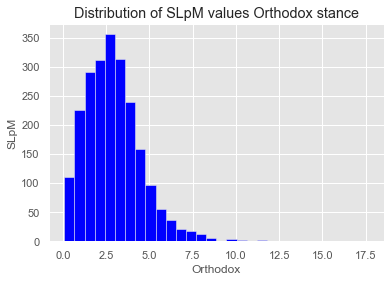

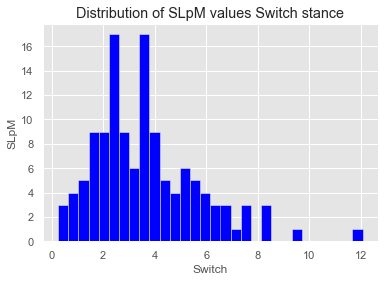

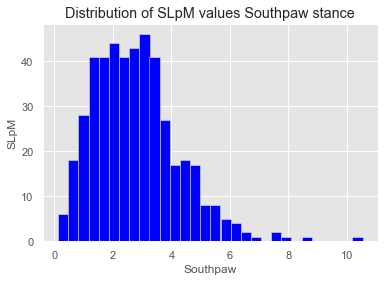

In [148]:
#They're all mount-shaped, however, we notice quite a few outliers
for f in df['stance'].unique()[0:3]:
    plt.hist(df[df['stance']==f]['SLpM'], color='blue', bins=30)
    plt.title(f'Distribution of SLpM values {f} stance')
    plt.xlabel(f)
    plt.ylabel('SLpM')
    plt.savefig('Stance_normality.png')
    plt.show()

In [149]:
'''Conducting Kolgorov-Smirnov test. p-values are all below 0.05 which suggests 
not normal distribution, however, this test is sensitive to outliers and we're
looking for enough normality to conduct ANOVA'''
for f in df['stance'].unique()[0:3]:
    normality_test = kstest_normal(df[df['stance']==f]['SLpM'])
    print(f'''P value for {f} category: {normality_test[1]}''') 

P value for Orthodox category: 0.0009999999999998899
P value for Switch category: 0.0037611734838932497
P value for Southpaw category: 0.0009999999999998899


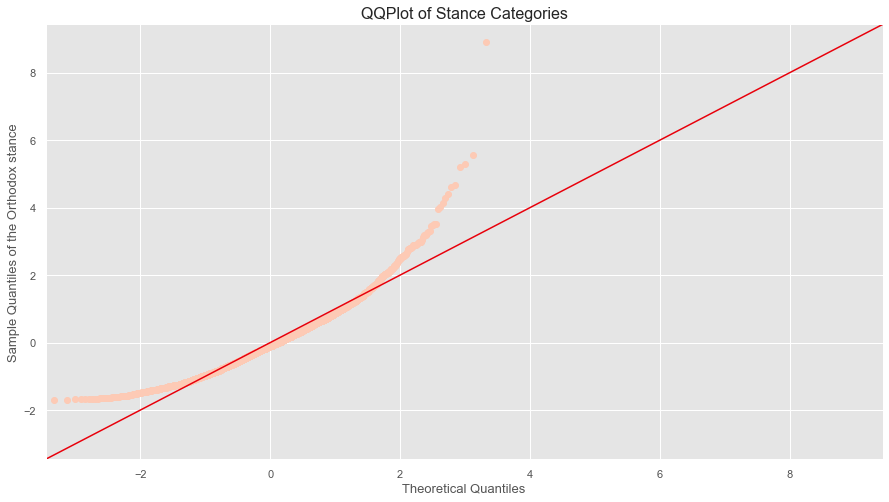

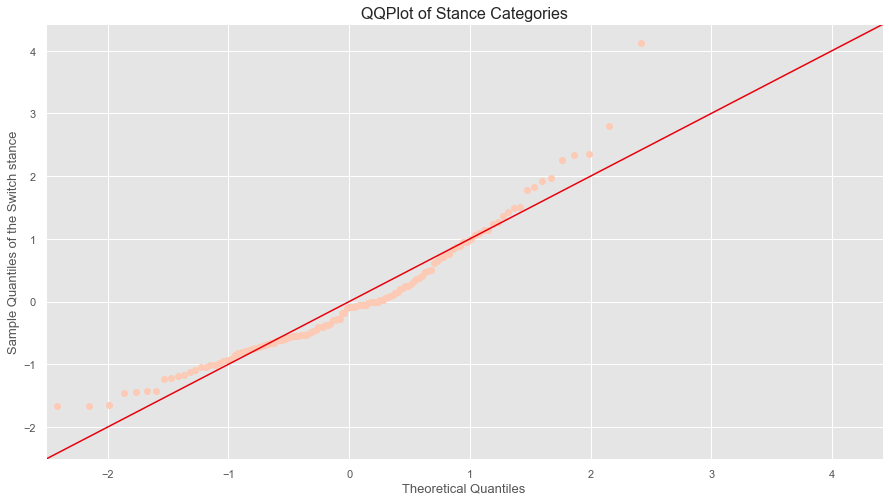

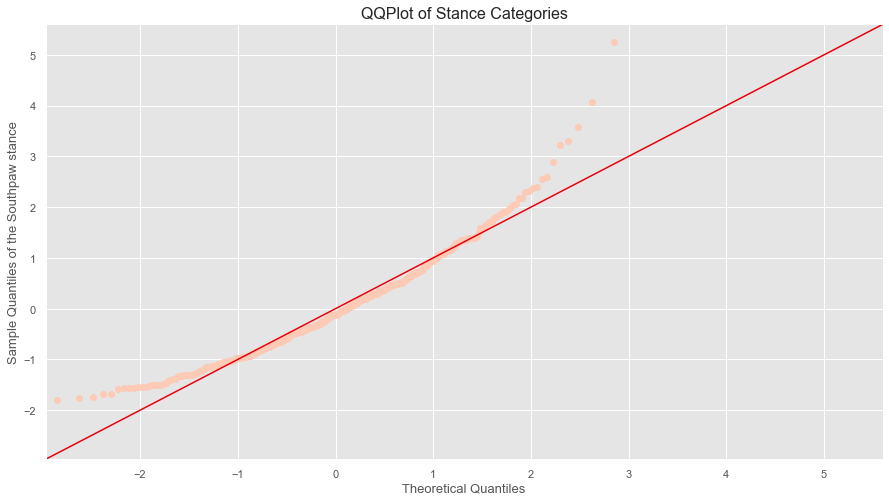

In [150]:
#Let's check theoretical vs actual quantiles and see how much they differ
for f in df['stance'].unique():
    fig = qqplot(df[df['stance']==f]['SLpM'], line = '45', fit=True)
    ax = plt.gca()
    fig.set_size_inches(15, 8)
    ax.set_xlabel('Theoretical Quantiles', fontsize=13)
    ax.set_ylabel(f'Sample Quantiles of the {f} stance', fontsize=13)
    ax.set_title("QQPlot of Stance Categories", fontsize=16)
plt.show()
#They look even enough

In [151]:
#Now let's conduct Shapiro-Wilk test for more confident results
for f in df['stance'].unique():
    print(f'''P-value for {f} stance: {shapiro(df[df['stance']==f]['SLpM']).pvalue}''') 

P-value for Orthodox stance: 1.1392201938282288e-30
P-value for Switch stance: 2.7280493668513373e-05
P-value for Southpaw stance: 4.728488781080564e-11


##### 2. Distribution of Residuals

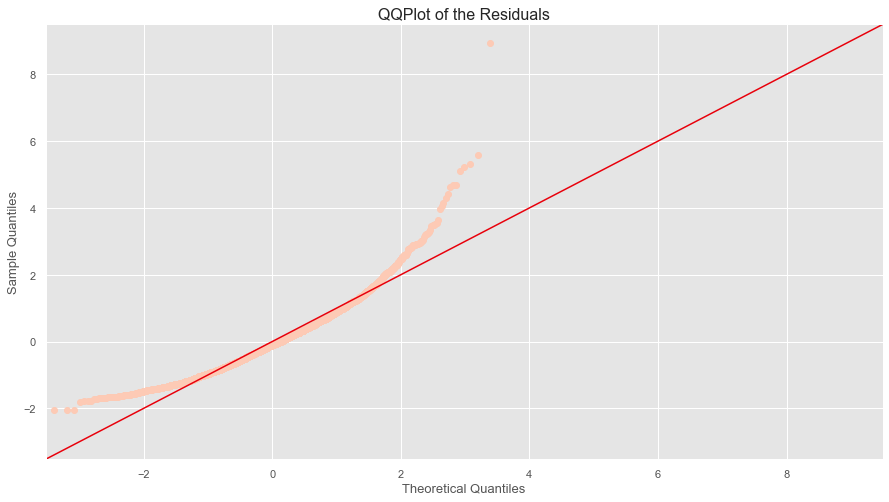

In [152]:
#It's considered fairly on the linear line. We've opted to be a bit less rigid here
stance = ols("SLpM ~ C(stance)", data = df).fit()
residuals = stance.resid

fig = qqplot(residuals, line = '45', fit=True)

ax = plt.gca()
fig.set_size_inches(15, 8)
ax.set_xlabel("Theoretical Quantiles", fontsize=13)
ax.set_ylabel("Sample Quantiles", fontsize=13)
ax.set_title("QQPlot of the Residuals", fontsize=16)
plt.savefig('Residuals.png')
plt.show()

##### 3. Equal variance 

In [153]:
'''This is where our assumption is being violated. 
As you see, Orthodox and Southpaw fighter's standard deviation
is fairly close. Unfortunately, that's not the case for the fighters
with a Switch stance'''

df.groupby('stance')['SLpM'].describe()['std'].to_frame() 

,std
stance,
Orthodox,1.656250
Southpaw,1.476562
Switch,2.048828


In [154]:
homoscedasticity_test = levene(df[df['stance']=='Orthodox']['SLpM'], df[df['stance']=='Southpaw']['SLpM'],
                              df[df['stance']=='Switch']['SLpM'])

print(f'''Levene test p-value: {homoscedasticity_test[1]}''')

Levene test p-value: 0.001083011740234121


#### ~Test

In [155]:
#For the reason above, we conduct a more robust Welch test for unequal variances
pg.welch_anova(dv='SLpM', between='stance', data=df)
#p-val less than 0.05. We can reject the null hypothesis

,Source,ddof1,ddof2,F,p-unc,np2
0,stance,2,299.227914,9.665265,0.000086,0.009497


In [156]:
#Lastly, we're checking pairwise difference. Switch stance significant mean in difference with others 
pg.pairwise_gameshowell(dv='SLpM', between='stance', data=df)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Orthodox,Southpaw,2.921875,2.796875,0.125000,0.077076,1.621766,716.618842,0.237073,0.082847
1,Orthodox,Switch,2.921875,3.650391,-0.728516,0.184975,-3.938451,135.418963,0.000382,-0.359041
2,Southpaw,Switch,2.796875,3.650391,-0.853516,0.194246,-4.394001,163.767947,0.000059,-0.439785
